## Análisis predictivo del aprovechamiento general del corte de carne tipo diezmillo choice con redes neuronales

El presente análisis se muestra el uso de redes neuronales para predecir el nivel de aprovechamiento (eficacia) en el proceso de corte de piezas base de carne tipo diezmillo choice, dentro del área de producción de una carnicería.

Por cuestiones legales no se incluyen información del origen de la información.

### Presenta: Carlos Alberto Rábago Figueroa

#### Descripción de variables del Dataset:
								
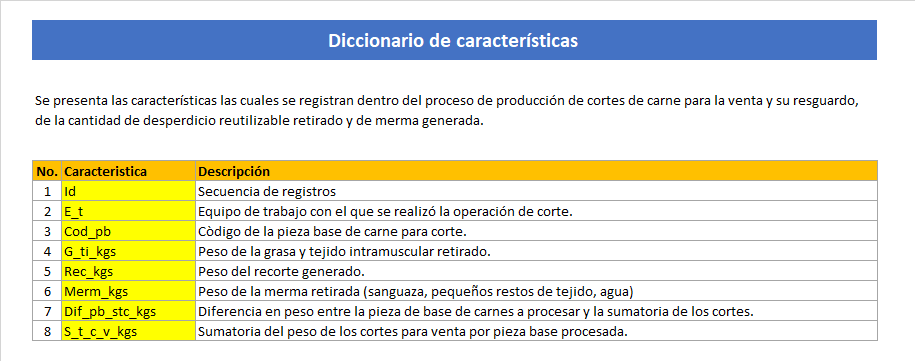

<img src="gh.png" width="80" height="80" align="left"/>

 Repositorio en GitHub del análisis: https://github.com/CarlosRabago/An-lisis_Predictivo_RN

#### Obtención de los datos

In [28]:
#importar librerias
import pandas as pd

In [29]:
#Obtener los datos
dfo = pd.read_csv("M_DCD_C4_0.93.csv",sep=",",encoding = 'latin-1')
df = dfo.copy()

In [30]:
#vistazo rápido a la estructura de los datos
df.tail()

,Id,Cod_pb,E_t,S_t_c_v_kgs,Rec_kgs,G_ti_kgs,Merm_kgs,Dif_pb_stc_kgs,Criterio
1142,1143,DCP,1,7.365,0.0,0.440,0.585,0.050,MA
1143,1144,DCP,1,6.350,0.0,0.475,0.730,0.040,MA
1144,1145,DCP,1,5.125,0.0,0.345,0.375,0.025,MA
1145,1146,DCP,1,9.900,0.0,0.395,0.555,0.045,MA
1146,1147,DCP,1,9.535,0.0,0.265,0.345,0.045,BA


El dataset cuenta con 1,146 registros, y 8 caracteristicas.

#### Limpieza de los datos
Verificar que el set de datos no contenga valores desconocidos.

In [31]:
df.isna().sum()

Id                0
Cod_pb            0
E_t               0
S_t_c_v_kgs       0
Rec_kgs           0
G_ti_kgs          0
Merm_kgs          0
Dif_pb_stc_kgs    0
Criterio          0
dtype: int64

comprobamos que no faltan valores.

#### Manejo de datos categóricos

La columna de `"E_t"` donde se se registra el uso del equipo de trabajo realmente es categórica, no numérica, es decir, 1 significa "Ambas", 2 "Cuchillo", 3 "Maquina_de_corte". Cuando ocurre esto, se usa la técnica de codificación one-hot, básicamente, consiste en crear características "ficticias" para cada valor único en la columna de características.

La codificación one-hot encoding asigna a los datos de entrada su propio vector y les da un valor 1 o 0.
    
En nuestro caso, usaremos el método pop() que proporciona pandas para extraer de los datos de la columna E_t, y se sustituira por tres nuevas columnas.    

In [32]:
origin = df.pop('E_t')

df['E_T_Ambas'] = (origin == 1)*1.0
df['E_T_Cuchillo'] = (origin == 2)*1.0
df['E_T_Maq._de_Corte'] = (origin == 3)*1.0

In [33]:
#visulización de los datos
df.tail()

,Id,Cod_pb,S_t_c_v_kgs,Rec_kgs,G_ti_kgs,Merm_kgs,Dif_pb_stc_kgs,Criterio,E_T_Ambas,E_T_Cuchillo,E_T_Maq._de_Corte
1142,1143,DCP,7.365,0.0,0.440,0.585,0.050,MA,1.0,0.0,0.0
1143,1144,DCP,6.350,0.0,0.475,0.730,0.040,MA,1.0,0.0,0.0
1144,1145,DCP,5.125,0.0,0.345,0.375,0.025,MA,1.0,0.0,0.0
1145,1146,DCP,9.900,0.0,0.395,0.555,0.045,MA,1.0,0.0,0.0
1146,1147,DCP,9.535,0.0,0.265,0.345,0.045,BA,1.0,0.0,0.0


Eliminemos la columna Id y Cod_pb

In [34]:
df = df.drop(['Id','Cod_pb'], axis=1)

In [35]:
df.tail()

,S_t_c_v_kgs,Rec_kgs,G_ti_kgs,Merm_kgs,Dif_pb_stc_kgs,Criterio,E_T_Ambas,E_T_Cuchillo,E_T_Maq._de_Corte
1142,7.365,0.0,0.440,0.585,0.050,MA,1.0,0.0,0.0
1143,6.350,0.0,0.475,0.730,0.040,MA,1.0,0.0,0.0
1144,5.125,0.0,0.345,0.375,0.025,MA,1.0,0.0,0.0
1145,9.900,0.0,0.395,0.555,0.045,MA,1.0,0.0,0.0
1146,9.535,0.0,0.265,0.345,0.045,BA,1.0,0.0,0.0


#### Verifiquemos la correlación entre los datos

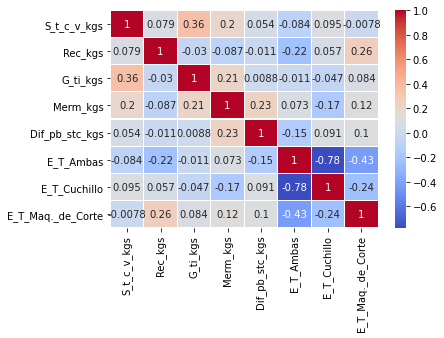

In [36]:
import seaborn as sns
fig = sns.heatmap(df.corr(),annot=True,cmap='coolwarm',linewidths=0.2)

Se observa correlación de baja a negativa entre las caracteristicas.

#### Inspeccione los datos

Revisemos rapidamente la distribucion conjunta de un par de columnas de la muestra.

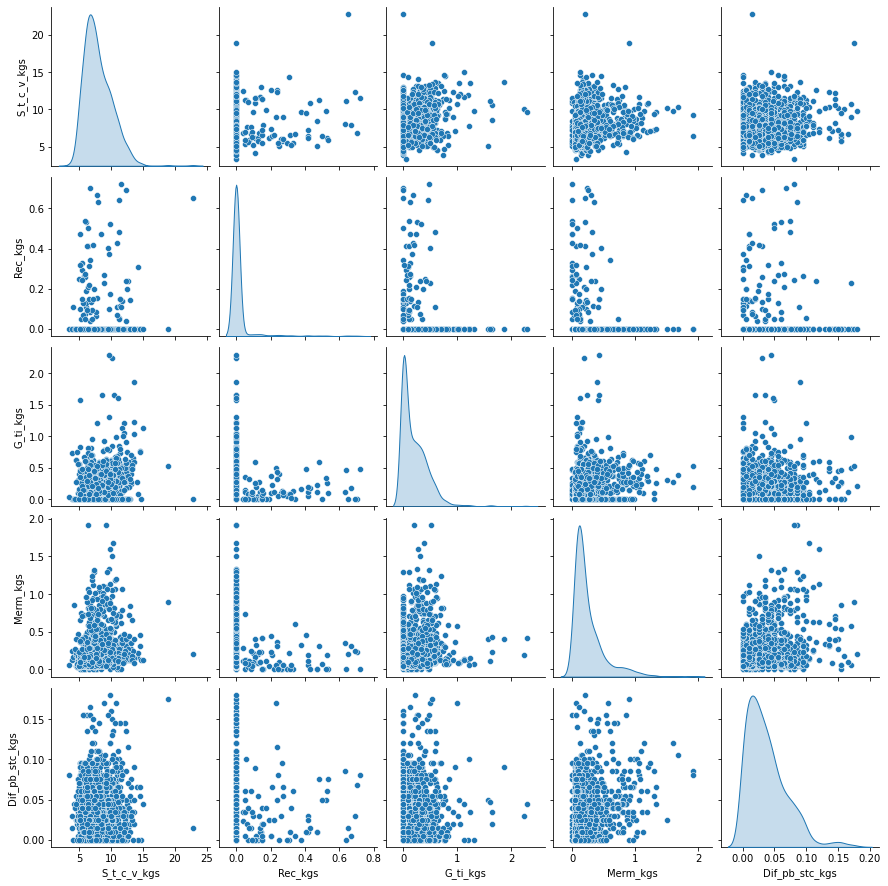

In [37]:
sns.pairplot(df[["S_t_c_v_kgs", "Rec_kgs", "G_ti_kgs", "Merm_kgs", "Dif_pb_stc_kgs"]], diag_kind="kde")

Tambien revisemos las estadisticas generales:

In [38]:
df.describe()

,S_t_c_v_kgs,Rec_kgs,G_ti_kgs,Merm_kgs,Dif_pb_stc_kgs,E_T_Ambas,E_T_Cuchillo,E_T_Maq._de_Corte
count,1147.000000,1147.000000,1147.000000,1147.000000,1147.000000,1147.000000,1147.000000,1147.000000
mean,7.979757,0.017004,0.203407,0.253299,0.037817,0.585004,0.299041,0.115955
std,2.139147,0.080491,0.259500,0.256086,0.031670,0.492936,0.458038,0.320310
min,3.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.400000,0.000000,0.000000,0.090000,0.015000,0.000000,0.000000,0.000000
50%,7.590000,0.000000,0.120000,0.160000,0.030000,1.000000,0.000000,0.000000
75%,9.317500,0.000000,0.332500,0.320000,0.055000,1.000000,1.000000,0.000000
max,22.831000,0.720000,2.300000,1.920000,0.180000,1.000000,1.000000,1.000000


#### Separamos las caracteristicas de las Etiquetas

Separe el valor objetivo, o la "etiqueta" de las caracteristicas. Esta etiqueta es el valor que entrenara el modelo para predecir.

In [39]:
import numpy as np

from sklearn.model_selection import train_test_split

X_df = df
X_df = X_df.drop(['Criterio'], axis=1)
y_df = df['Criterio']
y_df = [0 if x == 'BA' else 1 for x in y_df]

#### Dividamos los datos en set de entrenamiento y de prueba.

In [40]:
# El tamaño de la muestra para prueba va ser del 30 % de los datos y el otro 70 % de la muestra para entrenamiento.
# Las semillas aleatorias enteras populares son 0 y 42, para este caso se eligio 42.
# para más información consultar: 
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

x_tr, x_ts, y_tr, y_ts = train_test_split(X_df, y_df, test_size = 0.3, random_state = 42)

y_tr = np.asarray(y_tr, dtype = np.int)
y_ts = np.asarray(y_ts, dtype = np.int)

y_tr = np.reshape(y_tr, [802,1])
y_ts = np.reshape(y_ts, [345,1])

print(x_ts.shape)
print(x_tr.shape)
print(y_ts.shape)
print(y_tr.shape)

(345, 8)
(802, 8)
(345, 1)
(802, 1)


#### Revisemos rapidamente la distribucion conjunta de un par de columnas de la muestra de entrenamiento.

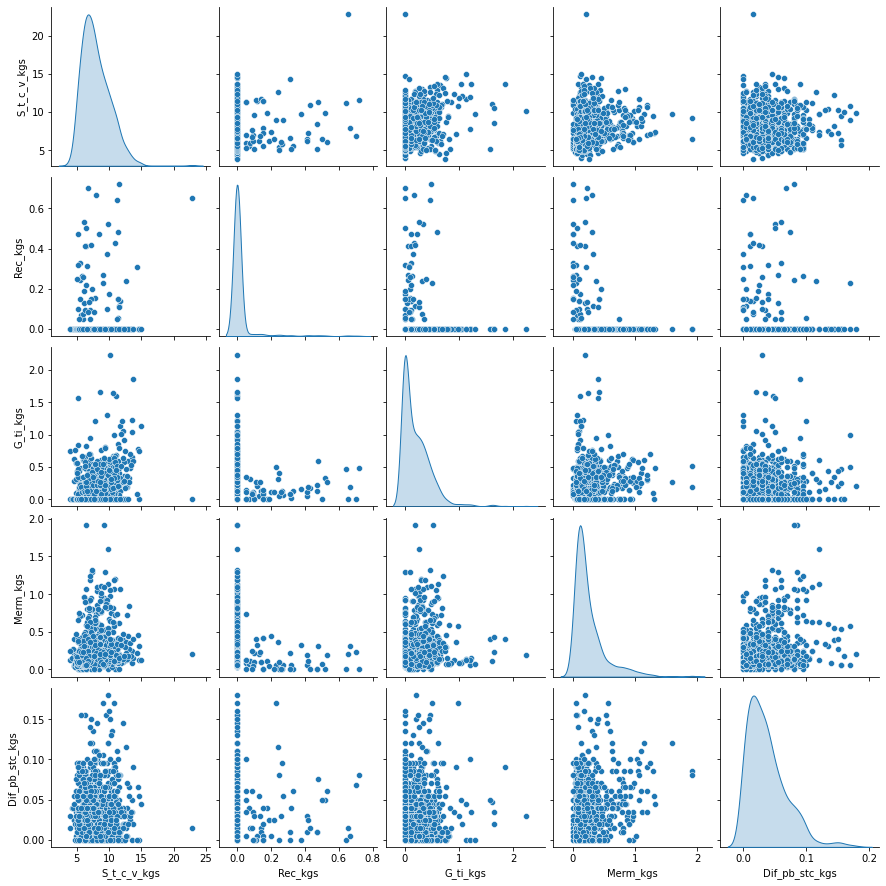

In [41]:
sns.pairplot(x_tr[["S_t_c_v_kgs", "Rec_kgs", "G_ti_kgs", "Merm_kgs", "Dif_pb_stc_kgs"]], diag_kind="kde")

Revisemos las estadisticas del conjunto de entrenamiento:

In [42]:
x_tr_stats = x_tr.describe()
x_tr_stats = x_tr_stats.transpose()
x_tr_stats

,count,mean,std,min,25%,50%,75%,max
S_t_c_v_kgs,802.0,7.971411,2.152102,3.895,6.37625,7.5925,9.29625,22.831
Rec_kgs,802.0,0.018338,0.083843,0.000,0.00000,0.0000,0.00000,0.720
G_ti_kgs,802.0,0.210746,0.269006,0.000,0.00000,0.1250,0.33500,2.240
Merm_kgs,802.0,0.254741,0.258318,0.000,0.09000,0.1650,0.32000,1.920
Dif_pb_stc_kgs,802.0,0.037856,0.031414,0.000,0.01500,0.0300,0.05500,0.180
E_T_Ambas,802.0,0.596010,0.491002,0.000,0.00000,1.0000,1.00000,1.000
E_T_Cuchillo,802.0,0.290524,0.454287,0.000,0.00000,0.0000,1.00000,1.000
E_T_Maq._de_Corte,802.0,0.113466,0.317360,0.000,0.00000,0.0000,0.00000,1.000


#### Revisemos rapidamente la distribucion conjunta de un par de columnas de la muestra de prueba.

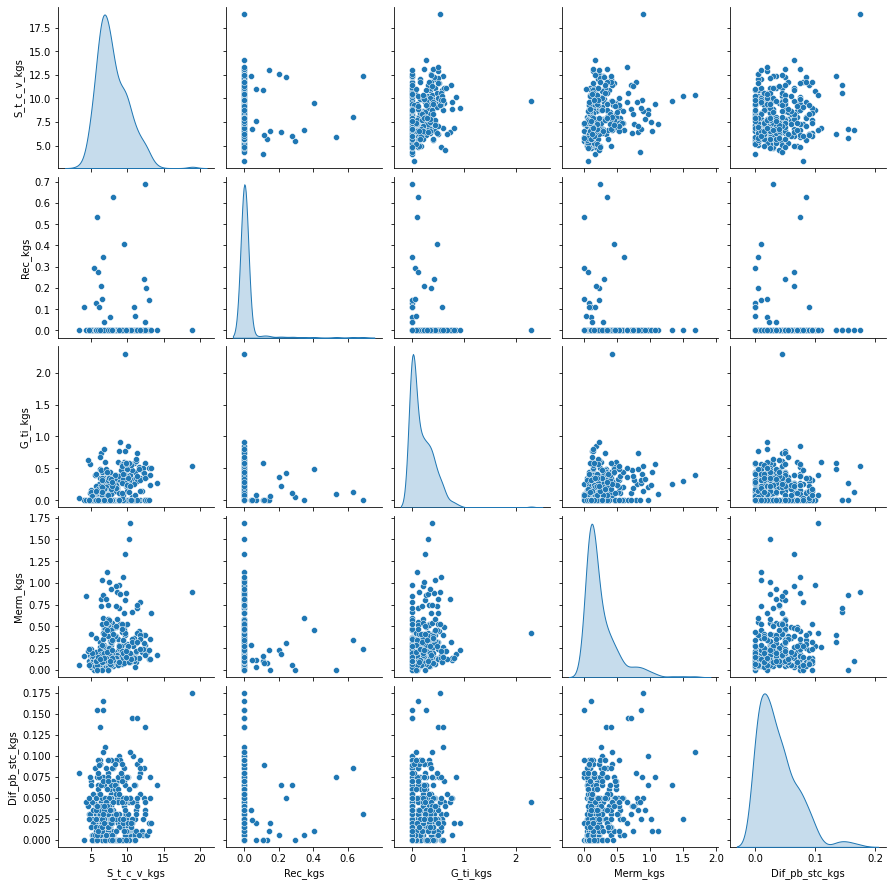

In [43]:
sns.pairplot(x_ts[["S_t_c_v_kgs", "Rec_kgs", "G_ti_kgs", "Merm_kgs", "Dif_pb_stc_kgs"]], diag_kind="kde")

Revisemos las estadisticas del conjunto de prueba:

In [44]:
x_ts_stats = x_ts.describe()
x_ts_stats = x_ts_stats.transpose()
x_ts_stats

,count,mean,std,min,25%,50%,75%,max
S_t_c_v_kgs,345.0,7.999157,2.111698,3.4,6.500,7.570,9.400,18.950
Rec_kgs,345.0,0.013904,0.072121,0.0,0.000,0.000,0.000,0.690
G_ti_kgs,345.0,0.186348,0.235417,0.0,0.000,0.115,0.325,2.300
Merm_kgs,345.0,0.249945,0.251159,0.0,0.090,0.155,0.325,1.685
Dif_pb_stc_kgs,345.0,0.037728,0.032305,0.0,0.015,0.030,0.055,0.175
E_T_Ambas,345.0,0.559420,0.497178,0.0,0.000,1.000,1.000,1.000
E_T_Cuchillo,345.0,0.318841,0.466704,0.0,0.000,0.000,1.000,1.000
E_T_Maq._de_Corte,345.0,0.121739,0.327459,0.0,0.000,0.000,0.000,1.000


#### Normalizar los datos

Es parte de las buenas prácticas normalizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo en teoría es capaz de converger sin normalización de características, tambien esto puede dificultar el entrenamiento y hacer que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

Nota: Aunque generamos intencionalmente estas estadísticas solo del conjunto de datos de entrenamiento, estas estadísticas también se utilizarán para normalizar el conjunto de datos de prueba. Necesitamos hacer eso para proyectar el conjunto de datos de prueba en la misma distribución en la que el modelo ha sido entrenado.

In [45]:
from sklearn.preprocessing import MinMaxScaler, Normalizer

# Datos de entrenamiento
x_tr = MinMaxScaler().fit_transform(x_tr)
print("Datos de entrenamiento:", x_tr.shape)

# Datos de prueba
x_ts = MinMaxScaler().fit_transform(x_ts)
print("Datos de prueba:", x_ts.shape)

Datos de entrenamiento: (802, 8)
Datos de prueba: (345, 8)


### Definición de la red neuronal 

In [46]:
#importamos librerias

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import Dropout

print("Version: ",tf.__version__)

Version:  2.4.1


#### Hiperparametros

In [47]:
# Hiperparametros

training_epochs = 2000 # Total de ciclos de entrenamiento (Total number of training epochs)

learning_rate = 0.01 # tasa de aprendizaje (the learning rate)

### Definición del modelo

##### Paso 1: se selecciona el modelo.

Se usará un modelo secuencial en el cual existe una entrada única y salida única, una ruta conduce a la parte inferior, solo hay una relación adyacente entre las capas y no hay conexión entre capas.

##### Paso 2: se construye la capa de red.

Es un modelo perceptrón multicapa con 8 entradas en la capa visible, 8 neuronas en la capa oculta, con una función de activación “Softmax”.
En la capa de salida una neurona, con una función de activación “Sigmoid”.

##### Paso 3: compilar

Sirve para compilar el proceso de aprendizaje a través del método Compile, dicho método recibe 3 argumentos: 
  * La función de perdida en nuestro caso usaremos la función “binary_crossentropy”.
  * El optimizador se usará SGD (descenso de gradiente estocástico).
  * La función de métricas establecidas con “accuracy”.
  

In [53]:
# creación del modelo

def create_model():
   
    # Modelo secuencial de Keras
    model = tf.keras.Sequential()
    
    # Capa oculta "Hidden layer"
    model.add(tf.keras.layers.Dense(8, input_dim=8,activation='softmax'))
   
    # Capa de salida "Output layer"
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compilación (Compile a model)
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.SGD(learning_rate),
                  metrics=['accuracy'])
    return model


model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


##### Paso 4: Ajustar la red

Una vez compilada la red, se puede ajustar, lo que significa adaptar los pesos a un conjunto de datos de formación. El ajuste de la red requiere que se especifiquen los datos de formación, tanto una matriz de patrones de entrada, X, como una matriz de patrones de salida coincidentes. La red se forma utilizando el algoritmo de retropropagación y se optimiza de acuerdo con el algoritmo de optimización y la función de pérdida especificados al compilar el modelo.

In [49]:
# Ajustar la red
results = model.fit(
    x_tr, y_tr,
    epochs= training_epochs,
    validation_data = (x_ts, y_ts),
    verbose = 1
)

Epoch 1/2000
26/26 [==============================] - 5s 116ms/step - loss: 0.6708 - accuracy: 0.6176 - val_loss: 0.6626 - val_accuracy: 0.6435
Epoch 2/2000
26/26 [==============================] - 0s 11ms/step - loss: 0.6787 - accuracy: 0.5892 - val_loss: 0.6622 - val_accuracy: 0.6435
Epoch 3/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.6696 - accuracy: 0.6202 - val_loss: 0.6618 - val_accuracy: 0.6435
Epoch 4/2000
26/26 [==============================] - 0s 12ms/step - loss: 0.6693 - accuracy: 0.6180 - val_loss: 0.6610 - val_accuracy: 0.6435
Epoch 5/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.6653 - accuracy: 0.6329 - val_loss: 0.6599 - val_accuracy: 0.6435
Epoch 6/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6734 - accuracy: 0.6040 - val_loss: 0.6589 - val_accuracy: 0.6435
Epoch 7/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6729 - accuracy: 0.6045 - val_loss: 0.6584 - val_accuracy: 0.6435


26/26 [==============================] - 0s 10ms/step - loss: 0.6573 - accuracy: 0.6298 - val_loss: 0.6492 - val_accuracy: 0.6435
Epoch 59/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.6631 - accuracy: 0.6161 - val_loss: 0.6494 - val_accuracy: 0.6435
Epoch 60/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6522 - accuracy: 0.6408 - val_loss: 0.6494 - val_accuracy: 0.6435
Epoch 61/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.6673 - accuracy: 0.6054 - val_loss: 0.6491 - val_accuracy: 0.6435
Epoch 62/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.6624 - accuracy: 0.6160 - val_loss: 0.6489 - val_accuracy: 0.6435
Epoch 63/2000
26/26 [==============================] - 0s 11ms/step - loss: 0.6676 - accuracy: 0.6066 - val_loss: 0.6489 - val_accuracy: 0.6435
Epoch 64/2000
26/26 [==============================] - 0s 11ms/step - loss: 0.6623 - accuracy: 0.6178 - val_loss: 0.6490 - val_accuracy: 0.6435
Epoch 6

Epoch 172/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6540 - accuracy: 0.6144 - val_loss: 0.6396 - val_accuracy: 0.6435
Epoch 173/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6548 - accuracy: 0.6133 - val_loss: 0.6394 - val_accuracy: 0.6435
Epoch 174/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6625 - accuracy: 0.6035 - val_loss: 0.6392 - val_accuracy: 0.6435
Epoch 175/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6609 - accuracy: 0.6000 - val_loss: 0.6388 - val_accuracy: 0.6435
Epoch 176/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6539 - accuracy: 0.6164 - val_loss: 0.6386 - val_accuracy: 0.6435
Epoch 177/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6538 - accuracy: 0.6184 - val_loss: 0.6385 - val_accuracy: 0.6435
Epoch 178/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6451 - accuracy: 0.6348 - val_loss: 0.6381 - val_accuracy:

Epoch 229/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6440 - accuracy: 0.6184 - val_loss: 0.6295 - val_accuracy: 0.6435
Epoch 230/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6563 - accuracy: 0.5949 - val_loss: 0.6294 - val_accuracy: 0.6435
Epoch 231/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6382 - accuracy: 0.6290 - val_loss: 0.6293 - val_accuracy: 0.6435
Epoch 232/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6455 - accuracy: 0.6197 - val_loss: 0.6294 - val_accuracy: 0.6435
Epoch 233/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6431 - accuracy: 0.6183 - val_loss: 0.6292 - val_accuracy: 0.6435
Epoch 234/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6551 - accuracy: 0.5982 - val_loss: 0.6289 - val_accuracy: 0.6435
Epoch 235/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.6468 - accuracy: 0.6104 - val_loss: 0.6290 - val_accuracy

26/26 [==============================] - 0s 10ms/step - loss: 0.6351 - accuracy: 0.6303 - val_loss: 0.6036 - val_accuracy: 0.7130
Epoch 342/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.6312 - accuracy: 0.6503 - val_loss: 0.6033 - val_accuracy: 0.7130
Epoch 343/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6219 - accuracy: 0.6424 - val_loss: 0.6030 - val_accuracy: 0.7130
Epoch 344/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.6286 - accuracy: 0.6439 - val_loss: 0.6024 - val_accuracy: 0.7101
Epoch 345/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6078 - accuracy: 0.6789 - val_loss: 0.6021 - val_accuracy: 0.7130
Epoch 346/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.6273 - accuracy: 0.6558 - val_loss: 0.6018 - val_accuracy: 0.7130
Epoch 347/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6253 - accuracy: 0.6467 - val_loss: 0.6012 - val_accuracy: 0.7101
Epo

Epoch 398/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6150 - accuracy: 0.6769 - val_loss: 0.5835 - val_accuracy: 0.7594
Epoch 399/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.5967 - accuracy: 0.7142 - val_loss: 0.5835 - val_accuracy: 0.7565
Epoch 400/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.6058 - accuracy: 0.7008 - val_loss: 0.5834 - val_accuracy: 0.7565
Epoch 401/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6091 - accuracy: 0.6963 - val_loss: 0.5831 - val_accuracy: 0.7565
Epoch 402/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.6083 - accuracy: 0.7023 - val_loss: 0.5827 - val_accuracy: 0.7594
Epoch 403/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.6007 - accuracy: 0.7124 - val_loss: 0.5823 - val_accuracy: 0.7623
Epoch 404/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.5894 - accuracy: 0.7341 - val_loss: 0.5823 - val_accura

26/26 [==============================] - 0s 11ms/step - loss: 0.5734 - accuracy: 0.7236 - val_loss: 0.5356 - val_accuracy: 0.7884
Epoch 511/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.5668 - accuracy: 0.7373 - val_loss: 0.5352 - val_accuracy: 0.7884
Epoch 512/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.5757 - accuracy: 0.7209 - val_loss: 0.5348 - val_accuracy: 0.7884
Epoch 513/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.5653 - accuracy: 0.7394 - val_loss: 0.5343 - val_accuracy: 0.7884
Epoch 514/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.5640 - accuracy: 0.7354 - val_loss: 0.5335 - val_accuracy: 0.7884
Epoch 515/2000
26/26 [==============================] - 0s 11ms/step - loss: 0.5699 - accuracy: 0.7353 - val_loss: 0.5327 - val_accuracy: 0.7884
Epoch 516/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.5615 - accuracy: 0.7429 - val_loss: 0.5328 - val_accuracy: 0.7884


Epoch 623/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.5224 - accuracy: 0.7554 - val_loss: 0.4757 - val_accuracy: 0.8174
Epoch 624/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.5167 - accuracy: 0.7589 - val_loss: 0.4754 - val_accuracy: 0.8174
Epoch 625/2000
26/26 [==============================] - 0s 11ms/step - loss: 0.5164 - accuracy: 0.7591 - val_loss: 0.4753 - val_accuracy: 0.8232
Epoch 626/2000
26/26 [==============================] - 0s 11ms/step - loss: 0.5246 - accuracy: 0.7567 - val_loss: 0.4754 - val_accuracy: 0.8290
Epoch 627/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.5134 - accuracy: 0.7690 - val_loss: 0.4742 - val_accuracy: 0.8232
Epoch 628/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.5113 - accuracy: 0.7693 - val_loss: 0.4737 - val_accuracy: 0.8261
Epoch 629/2000
26/26 [==============================] - 0s 8ms/step - loss: 0.5136 - accuracy: 0.7609 - val_loss: 0.4734 - val_accu

26/26 [==============================] - 0s 9ms/step - loss: 0.4499 - accuracy: 0.8159 - val_loss: 0.4138 - val_accuracy: 0.8667
Epoch 736/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.4524 - accuracy: 0.8046 - val_loss: 0.4141 - val_accuracy: 0.8667
Epoch 737/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.4553 - accuracy: 0.8073 - val_loss: 0.4130 - val_accuracy: 0.8696
Epoch 738/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.4610 - accuracy: 0.7960 - val_loss: 0.4134 - val_accuracy: 0.8696
Epoch 739/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.4531 - accuracy: 0.8121 - val_loss: 0.4122 - val_accuracy: 0.8725
Epoch 740/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.4666 - accuracy: 0.8085 - val_loss: 0.4118 - val_accuracy: 0.8696
Epoch 741/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.4757 - accuracy: 0.7719 - val_loss: 0.4106 - val_accuracy: 0.8696
Epoch 7

26/26 [==============================] - 0s 12ms/step - loss: 0.3897 - accuracy: 0.8525 - val_loss: 0.3530 - val_accuracy: 0.8957
Epoch 848/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.3971 - accuracy: 0.8535 - val_loss: 0.3526 - val_accuracy: 0.8957
Epoch 849/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.3871 - accuracy: 0.8687 - val_loss: 0.3522 - val_accuracy: 0.8957
Epoch 850/2000
26/26 [==============================] - 0s 8ms/step - loss: 0.3976 - accuracy: 0.8584 - val_loss: 0.3512 - val_accuracy: 0.8957
Epoch 851/2000
26/26 [==============================] - 0s 8ms/step - loss: 0.3871 - accuracy: 0.8577 - val_loss: 0.3512 - val_accuracy: 0.8957
Epoch 852/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.4031 - accuracy: 0.8363 - val_loss: 0.3498 - val_accuracy: 0.8957
Epoch 853/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.4063 - accuracy: 0.8386 - val_loss: 0.3488 - val_accuracy: 0.8986
Epoch

Epoch 960/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.3368 - accuracy: 0.8921 - val_loss: 0.2980 - val_accuracy: 0.9101
Epoch 961/2000
26/26 [==============================] - 0s 11ms/step - loss: 0.3354 - accuracy: 0.8973 - val_loss: 0.2974 - val_accuracy: 0.9101
Epoch 962/2000
26/26 [==============================] - 0s 11ms/step - loss: 0.3443 - accuracy: 0.8828 - val_loss: 0.2971 - val_accuracy: 0.9101
Epoch 963/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.3345 - accuracy: 0.8947 - val_loss: 0.2957 - val_accuracy: 0.9101
Epoch 964/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.3385 - accuracy: 0.8835 - val_loss: 0.2952 - val_accuracy: 0.9101
Epoch 965/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.3338 - accuracy: 0.8907 - val_loss: 0.2948 - val_accuracy: 0.9101
Epoch 966/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.3433 - accuracy: 0.8812 - val_loss: 0.2951 - val_acc

26/26 [==============================] - 0s 10ms/step - loss: 0.2931 - accuracy: 0.9004 - val_loss: 0.2538 - val_accuracy: 0.9159
Epoch 1073/2000
26/26 [==============================] - 0s 11ms/step - loss: 0.2927 - accuracy: 0.8956 - val_loss: 0.2538 - val_accuracy: 0.9159
Epoch 1074/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.3013 - accuracy: 0.8950 - val_loss: 0.2532 - val_accuracy: 0.9130
Epoch 1075/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2977 - accuracy: 0.8880 - val_loss: 0.2529 - val_accuracy: 0.9130
Epoch 1076/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2961 - accuracy: 0.8965 - val_loss: 0.2526 - val_accuracy: 0.9130
Epoch 1077/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2903 - accuracy: 0.8922 - val_loss: 0.2524 - val_accuracy: 0.9130
Epoch 1078/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2855 - accuracy: 0.9071 - val_loss: 0.2520 - val_accuracy: 0.9159

26/26 [==============================] - 0s 9ms/step - loss: 0.2627 - accuracy: 0.9113 - val_loss: 0.2250 - val_accuracy: 0.9159
Epoch 1185/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.2612 - accuracy: 0.9108 - val_loss: 0.2250 - val_accuracy: 0.9159
Epoch 1186/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.2494 - accuracy: 0.9125 - val_loss: 0.2247 - val_accuracy: 0.9159
Epoch 1187/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.2707 - accuracy: 0.8983 - val_loss: 0.2247 - val_accuracy: 0.9159
Epoch 1188/2000
26/26 [==============================] - 0s 8ms/step - loss: 0.2582 - accuracy: 0.9084 - val_loss: 0.2239 - val_accuracy: 0.9188
Epoch 1189/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.2539 - accuracy: 0.9228 - val_loss: 0.2240 - val_accuracy: 0.9130
Epoch 1190/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2592 - accuracy: 0.9190 - val_loss: 0.2238 - val_accuracy: 0.91

26/26 [==============================] - 0s 9ms/step - loss: 0.2254 - accuracy: 0.9178 - val_loss: 0.2070 - val_accuracy: 0.9217
Epoch 1297/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2360 - accuracy: 0.9164 - val_loss: 0.2070 - val_accuracy: 0.9246
Epoch 1298/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2467 - accuracy: 0.9185 - val_loss: 0.2066 - val_accuracy: 0.9217
Epoch 1299/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2350 - accuracy: 0.9245 - val_loss: 0.2062 - val_accuracy: 0.9246
Epoch 1300/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2310 - accuracy: 0.9201 - val_loss: 0.2072 - val_accuracy: 0.9217
Epoch 1301/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2393 - accuracy: 0.9091 - val_loss: 0.2067 - val_accuracy: 0.9246
Epoch 1302/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2287 - accuracy: 0.9170 - val_loss: 0.2047 - val_accuracy: 0.9246
E

26/26 [==============================] - 0s 9ms/step - loss: 0.2039 - accuracy: 0.9341 - val_loss: 0.1932 - val_accuracy: 0.9217
Epoch 1409/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.2173 - accuracy: 0.9242 - val_loss: 0.1939 - val_accuracy: 0.9217
Epoch 1410/2000
26/26 [==============================] - 0s 11ms/step - loss: 0.2151 - accuracy: 0.9213 - val_loss: 0.1930 - val_accuracy: 0.9217
Epoch 1411/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.2044 - accuracy: 0.9305 - val_loss: 0.1930 - val_accuracy: 0.9217
Epoch 1412/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2132 - accuracy: 0.9267 - val_loss: 0.1925 - val_accuracy: 0.9217
Epoch 1413/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2171 - accuracy: 0.9265 - val_loss: 0.1932 - val_accuracy: 0.9217
Epoch 1414/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2192 - accuracy: 0.9218 - val_loss: 0.1947 - val_accuracy: 0.921

26/26 [==============================] - 0s 9ms/step - loss: 0.1936 - accuracy: 0.9332 - val_loss: 0.1864 - val_accuracy: 0.9217
Epoch 1521/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2146 - accuracy: 0.9196 - val_loss: 0.1869 - val_accuracy: 0.9217
Epoch 1522/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2072 - accuracy: 0.9308 - val_loss: 0.1873 - val_accuracy: 0.9246
Epoch 1523/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.1945 - accuracy: 0.9334 - val_loss: 0.1873 - val_accuracy: 0.9246
Epoch 1524/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2129 - accuracy: 0.9196 - val_loss: 0.1886 - val_accuracy: 0.9217
Epoch 1525/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2064 - accuracy: 0.9266 - val_loss: 0.1873 - val_accuracy: 0.9246
Epoch 1526/2000
26/26 [==============================] - 0s 11ms/step - loss: 0.1939 - accuracy: 0.9383 - val_loss: 0.1869 - val_accuracy: 0.9246


26/26 [==============================] - 0s 9ms/step - loss: 0.1685 - accuracy: 0.9448 - val_loss: 0.1828 - val_accuracy: 0.9130
Epoch 1633/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2001 - accuracy: 0.9137 - val_loss: 0.1827 - val_accuracy: 0.9130
Epoch 1634/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.1822 - accuracy: 0.9441 - val_loss: 0.1828 - val_accuracy: 0.9130
Epoch 1635/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.1885 - accuracy: 0.9291 - val_loss: 0.1817 - val_accuracy: 0.9188
Epoch 1636/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2093 - accuracy: 0.9249 - val_loss: 0.1817 - val_accuracy: 0.9188
Epoch 1637/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.1999 - accuracy: 0.9246 - val_loss: 0.1822 - val_accuracy: 0.9159
Epoch 1638/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.2006 - accuracy: 0.9206 - val_loss: 0.1800 - val_accuracy: 0.9217


26/26 [==============================] - 0s 10ms/step - loss: 0.1689 - accuracy: 0.9447 - val_loss: 0.1805 - val_accuracy: 0.9159
Epoch 1745/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.1832 - accuracy: 0.9288 - val_loss: 0.1762 - val_accuracy: 0.9217
Epoch 1746/2000
26/26 [==============================] - 0s 12ms/step - loss: 0.1938 - accuracy: 0.9327 - val_loss: 0.1761 - val_accuracy: 0.9217
Epoch 1747/2000
26/26 [==============================] - 0s 12ms/step - loss: 0.1871 - accuracy: 0.9340 - val_loss: 0.1765 - val_accuracy: 0.9217
Epoch 1748/2000
26/26 [==============================] - 0s 14ms/step - loss: 0.1734 - accuracy: 0.9385 - val_loss: 0.1779 - val_accuracy: 0.9159
Epoch 1749/2000
26/26 [==============================] - 0s 13ms/step - loss: 0.1872 - accuracy: 0.9237 - val_loss: 0.1783 - val_accuracy: 0.9188
Epoch 1750/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.1889 - accuracy: 0.9267 - val_loss: 0.1788 - val_accuracy: 0.

26/26 [==============================] - 0s 13ms/step - loss: 0.1650 - accuracy: 0.9400 - val_loss: 0.1820 - val_accuracy: 0.9188
Epoch 1857/2000
26/26 [==============================] - 0s 13ms/step - loss: 0.1833 - accuracy: 0.9289 - val_loss: 0.1805 - val_accuracy: 0.9159
Epoch 1858/2000
26/26 [==============================] - 0s 14ms/step - loss: 0.1824 - accuracy: 0.9270 - val_loss: 0.1781 - val_accuracy: 0.9130
Epoch 1859/2000
26/26 [==============================] - 0s 12ms/step - loss: 0.1885 - accuracy: 0.9138 - val_loss: 0.1793 - val_accuracy: 0.9159
Epoch 1860/2000
26/26 [==============================] - 0s 11ms/step - loss: 0.1839 - accuracy: 0.9248 - val_loss: 0.1762 - val_accuracy: 0.9159
Epoch 1861/2000
26/26 [==============================] - 0s 12ms/step - loss: 0.1911 - accuracy: 0.9187 - val_loss: 0.1771 - val_accuracy: 0.9130
Epoch 1862/2000
26/26 [==============================] - 0s 13ms/step - loss: 0.1772 - accuracy: 0.9251 - val_loss: 0.1782 - val_accuracy: 0

26/26 [==============================] - 0s 9ms/step - loss: 0.1654 - accuracy: 0.9297 - val_loss: 0.1804 - val_accuracy: 0.9159
Epoch 1913/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.1921 - accuracy: 0.9167 - val_loss: 0.1810 - val_accuracy: 0.9159
Epoch 1914/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.1661 - accuracy: 0.9358 - val_loss: 0.1833 - val_accuracy: 0.9188
Epoch 1915/2000
26/26 [==============================] - 0s 10ms/step - loss: 0.1743 - accuracy: 0.9451 - val_loss: 0.1807 - val_accuracy: 0.9159
Epoch 1916/2000
26/26 [==============================] - 0s 9ms/step - loss: 0.1712 - accuracy: 0.9349 - val_loss: 0.1800 - val_accuracy: 0.9159
Epoch 1917/2000
26/26 [==============================] - 0s 11ms/step - loss: 0.1626 - accuracy: 0.9392 - val_loss: 0.1755 - val_accuracy: 0.9159
Epoch 1918/2000
26/26 [==============================] - 0s 11ms/step - loss: 0.1707 - accuracy: 0.9339 - val_loss: 0.1776 - val_accuracy: 0.913

##### Paso 5: Evaluar la red

El modelo evalúa la pérdida a través de todos los patrones de prueba, así como cualquier otra métrica especificada cuando se compiló el modelo, como ejemplo la precisión de clasificación, por lo tanto devuelve una lista de métricas de evaluación.

In [50]:
# Evaluación de la red

# Evaluación del set de entrenamiento. 
print("Evaluating on training set...")
(loss, accuracy) = model.evaluate(x_tr, y_tr, verbose=0)
print("loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

# Evaluación del set de prueba. 
print("Evaluating on testing set...")
(loss, accuracy) = model.evaluate(x_ts, y_ts, verbose=0)
print("loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Evaluating on training set...
loss=0.1716, accuracy: 92.8928%
Evaluating on testing set...
loss=0.1807, accuracy: 91.8841%


#### Gráficos de los ciclos para el cálculo de la precisión y de perdida.

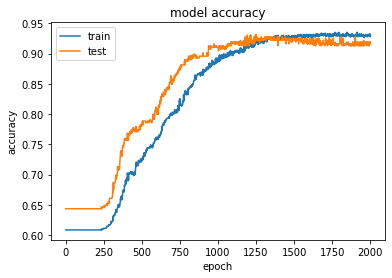

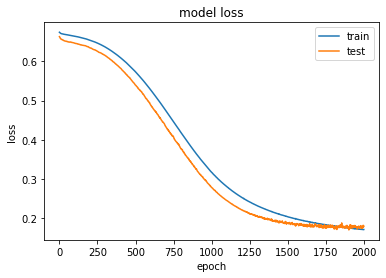

Maximum Loss : 0.6738

Minimum Loss : 0.1718

Loss difference : 0.5020


In [51]:
# Gráfico de los ciclos para el cálculo de la precisión de los conjuntos de datos de entrenamiento y validación.
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Gráfico de los ciclos para el cálculo de la perdida de los conjuntos de datos de entrenamiento y validación.
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Valor máximo de la perdida, Valor minimo de la perdida, Diferencia.
max_loss = np.max(results.history['loss'])
min_loss = np.min(results.history['loss'])
print("Maximum Loss : {:.4f}".format(max_loss))
print("")
print("Minimum Loss : {:.4f}".format(min_loss))
print("")
print("Loss difference : {:.4f}".format((max_loss - min_loss)))

#### Comentarios:
Se puede apreciar el aumento de la precisión de la predicción.

Se puede observar que el modelo tiene un rendimiento comparable tanto en el entrenamiento como en los conjuntos de validación.

#### Guardar el modelo final en .json y en HDF5

In [52]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("modelefc.h5")
print("El modelo ha sido guardado")


El modelo ha sido guardado


### Análisis de resultados y presentación

### La configuración con el mejor resultado fue:

El set de datos de entrenamiento se fijo en un 70 % de la muestra y el set de datos para prueba en 30 %.

El número de iteraciones se fijó en 2000, con un factor de aprendizaje de 0.01.

Un modelo perceptrón multicapa con 8 entradas en la capa visible, 8 neuronas en la capa oculta, con una función de activación “Softmax”. En la capa de salida una neurona, con una función de activación “Sigmoid”.

En el método compilación, la función de perdida "loss": “binary_crossentropy”, el optimizador “optimizer”: SGD, la función de métricas establecidas con “accuracy”.

### Fuentes de información

##### Bibliografía:

Python Deep Learning, Introducción práctica con keras y TensorFlow 2, Jordi Torres, 2020, Editorial Alfaomega.

##### Paginas web:

* https://www.tensorflow.org/
* https://keras.io/api/models/sequential/
* https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
* https://stackoverflow.com/questions/42763094/how-to-save-final-model-using-keras
* https://unipython.com/como-desarrollar-modelos-de-deep-learning-con-keras/
* https://faroit.com/keras-docs/1.0.1/getting-started/sequential-model-guide/#getting-started-with-the-keras-sequential-model


    
